# Data Brief 1: Energy Supply Workshop

## Client Brief

In this project, one important aspect is to analyse energy supply issues and curtailment in Orkney, specifically focusing on wind turbine performance data. You will evaluate constraints in the energy supply chain and propose demand management solutions to enhance system stability and reduce wastage. Any explorative data analysis or assumptions you make in suppy or demand would inform your solutions. In this data brief, we share some of the analysis we did as Kaluza, in case it helps in your work. 

### Objectives

1. **Analyze Turbine Data**: Examine power output, setpoints, and wind speeds to understand the curtailment trends.
2. **Identify Curtailment Reduction Solutions**: Propose methods to reduce renewable energy curtailment based on turbine telemetry data.

---

## 1: Analyzing Turbine Power Output Trends

Load the turbine telemetry data to analyze current supply patterns and constraints.

### Code

In this section, we load and examine the turbine telemetry data to understand the power output patterns over time. We also look at the setpoint values, which represent the target power output. By plotting these values, we can visualize any gaps between the actual and target output, which may indicate curtailment events.



In this task, we start by examining turbine telemetry data, focusing on the power output trends. This data will help us understand how actual power generation aligns with setpoints over time. Visualizing these patterns will highlight any discrepancies, which could indicate curtailment.



### Step 1: Load and Plot Turbine Data

Let's load the turbine telemetry data, containing timestamps, actual power output, setpoints, and wind speed. Plotting actual power output versus setpoint will help visualize any curtailment.


In [75]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load turbine telemetry dataset
tt = pd.read_csv('turbine_telemetry.csv', parse_dates=[0], index_col=0)
# tt['Timestamp'] = pd.to_datetime(tt['Timestamp'])


In [76]:
# it looks like the data is sampled at nearly 1 minute intervals
tt.head(10)

,Power_kw,Setpoint_kw,Wind_ms
Timestamp,,,
2015-05-28 00:00:23,80.0,900.0,4.9
2015-05-28 00:01:23,78.0,900.0,5.4
2015-05-28 00:02:23,52.0,900.0,4.9
2015-05-28 00:03:23,57.0,900.0,4.6
2015-05-28 00:04:23,54.0,900.0,4.6
2015-05-28 00:05:23,44.0,900.0,4.5
2015-05-28 00:06:23,62.0,900.0,4.5
2015-05-28 00:07:23,51.0,900.0,4.1
2015-05-28 00:08:23,155.0,900.0,6.4


In [77]:
# how to find out if that hypothesis is true? 
dt = pd.Series(tt.index).diff()
dt.max()
# assert dt.max() == dt.min()

Timedelta('98 days 00:01:07')

In [78]:
dt.min()

Timedelta('0 days 00:00:01')

In [79]:
one_min = pd.Timedelta(minutes=1)
(dt == one_min).sum() / len(dt)

0.9830848999098759

In [80]:
# how often is the power output above the setpoint? 
(tt.Power_kw > tt.Setpoint_kw).sum() / len(tt) # 10% of the time

0.13004517424619216

In [81]:
# all data from after 2017
tt[tt.index > '2017'].head()

,Power_kw,Setpoint_kw,Wind_ms
Timestamp,,,
2017-01-01 00:00:20,900.0,900.0,13.1
2017-01-01 00:01:20,756.0,900.0,12.4
2017-01-01 00:02:20,907.0,900.0,13.8
2017-01-01 00:03:20,906.0,900.0,13.3
2017-01-01 00:04:20,860.0,900.0,12.9


In [82]:
# all the data FROM 2017
mask = (tt.index.year == 2017) & (tt.index.month >= 5)
tt[mask].head()

,Power_kw,Setpoint_kw,Wind_ms
Timestamp,,,
2017-05-01 00:00:06,0.0,0.0,14.4
2017-05-01 00:01:06,0.0,0.0,13.6
2017-05-01 00:02:06,0.0,0.0,15.6
2017-05-01 00:03:06,0.0,0.0,12.4
2017-05-01 00:04:06,0.0,0.0,14.4


In [83]:
tt.Setpoint_kw.describe()

count    1.066921e+06
mean     8.106578e+02
std      2.615071e+02
min      0.000000e+00
25%      9.000000e+02
50%      9.000000e+02
75%      9.000000e+02
max      9.000000e+02
Name: Setpoint_kw, dtype: float64

In [84]:
tt.corr()

,Power_kw,Setpoint_kw,Wind_ms
Power_kw,1.000000,0.317703,0.647105
Setpoint_kw,0.317703,1.000000,-0.185084
Wind_ms,0.647105,-0.185084,1.000000


In [85]:
tt.describe()

,Power_kw,Setpoint_kw,Wind_ms
count,1.066934e+06,1.066921e+06,1.066931e+06
mean,3.671871e+02,8.106578e+02,9.955093e+00
std,3.399636e+02,2.615071e+02,5.453944e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.100000e+01,9.000000e+02,6.100000e+00
50%,2.510000e+02,9.000000e+02,9.000000e+00
75%,7.040000e+02,9.000000e+02,1.240000e+01
max,9.380000e+02,9.000000e+02,4.720000e+01


<AxesSubplot:xlabel='Wind_ms', ylabel='Power_kw'>

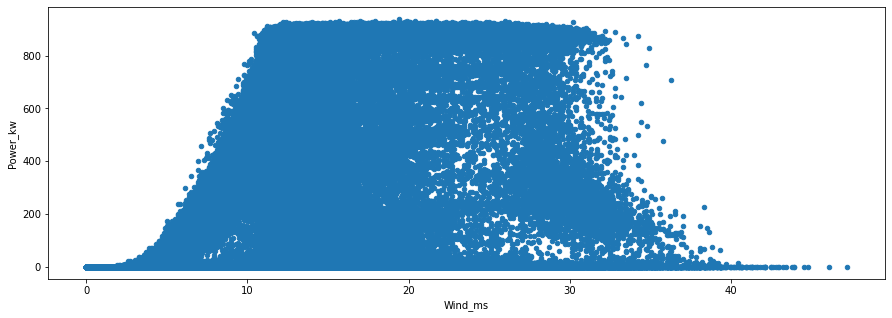

In [86]:
# to avoid replotting everytime you re-run the notebook, I suggest caching the image
# `alpha` -- opacity
tt.plot.scatter('Wind_ms', 'Power_kw', alpha=1, figsize=(15, 5)) # alpha here is important

<AxesSubplot:xlabel='Wind_ms', ylabel='Power_kw'>

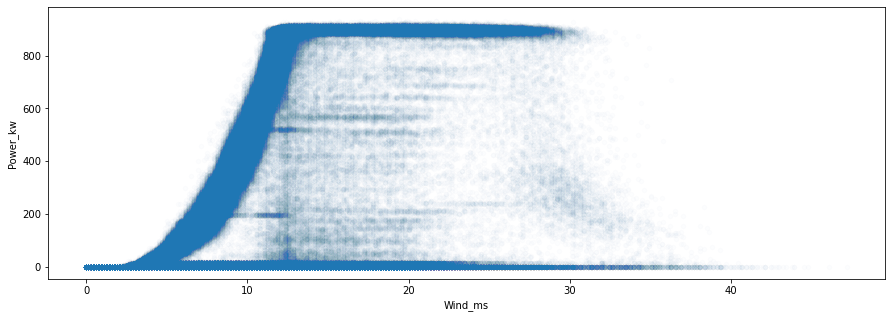

In [87]:
# to avoid replotting everytime you re-run the notebook, I suggest caching the image
tt.plot.scatter('Wind_ms', 'Power_kw', alpha=0.01, figsize=(15, 5)) # alpha here is important

In [88]:
# how to figure out what's the the smallest speed necessary to produce power
# there's a lot of similar thinking between Pandas and SQL
v_min = tt[(tt.loc[:, 'Power_kw'] >= 10.)].loc[:, 'Wind_ms'].quantile(0.1) # 10% quantile
v_min

5.0

In [89]:
# Some examples:
# we only want to use data when the turbine was not constrained
# there are two options here -- queries and filter 
# query is more SQL-ish
df = tt.query('Setpoint_kw==900').copy()

# remove data points when the wind speed is fast enough for power production but there is no power; turbine is probably manually switched off here
df.loc[((df.Wind_ms >= v_min) & (df.Power_kw.abs() <= 1e-5))] = np.nan

# remove all missing values from the dataframe
df = df.dropna(0, inplace=False)

/var/folders/r2/kqm91_nx4lzbwlgclwj3gnfm0000gp/T/ipykernel_82624/2002572880.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna(0, inplace=False)


<AxesSubplot:xlabel='Wind_ms', ylabel='Power_kw'>

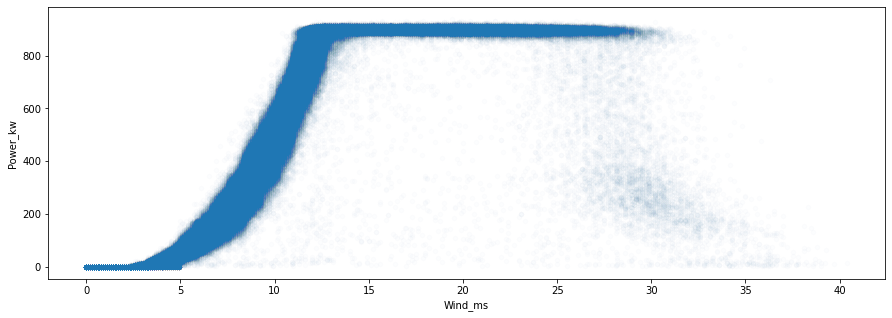

In [90]:
# let's attempt the scatter plot again
df.plot.scatter('Wind_ms', 'Power_kw', alpha=0.01, figsize=(15, 5)) # a lot cleaner!

In [91]:
# select bin locations
# from the data we can see that after about 16m/s, the power output is nearly at max
# NOTE: you could achieve a similar doing a quantiles query
wmax_ = df[df.Power_kw == df.Power_kw.quantile(0.90)].Wind_ms.quantile(0.5)
print(wmax_)
wmax = 17

15.8


In [92]:
bins = np.arange(0, wmax, .2)

# group data by bins
# advanced Pandas feature:
cuts = pd.cut(df.Wind_ms, bins) # <-- generating bins for the windspeep
print(cuts) # <-- remove comment to see the output
gp = df.Power_kw.groupby(cuts) # iterator

# hack -- for visualisation purposes only
print()
for n, g in gp:
    print(n, g)
    break

Timestamp
2015-05-28 00:00:23    (4.8, 5.0]
2015-05-28 00:01:23    (5.2, 5.4]
2015-05-28 00:02:23    (4.8, 5.0]
2015-05-28 00:03:23    (4.4, 4.6]
2015-05-28 00:04:23    (4.4, 4.6]
                          ...    
2018-01-11 06:10:32    (5.8, 6.0]
2018-01-11 06:11:32    (5.6, 5.8]
2018-01-11 06:12:32    (5.6, 5.8]
2018-01-11 06:13:32    (5.4, 5.6]
2018-01-11 06:14:32    (5.4, 5.6]
Name: Wind_ms, Length: 931575, dtype: category
Categories (84, interval[float64, right]): [(0.0, 0.2] < (0.2, 0.4] < (0.4, 0.6] < (0.6, 0.8] ... (16.0, 16.2] < (16.2, 16.4] < (16.4, 16.6] < (16.6, 16.8]]

(0.0, 0.2] Timestamp
2015-05-30 22:35:23    0.0
2015-09-15 17:42:30    0.0
2015-09-15 17:43:30    0.0
2015-09-16 19:56:30    0.0
2015-09-16 20:11:30    0.0
                      ... 
2018-01-03 03:01:32    0.0
2018-01-03 11:14:32    0.0
2018-01-03 11:15:32    0.0
2018-01-10 14:37:32    0.0
2018-01-10 15:52:32    0.0
Name: Power_kw, Length: 575, dtype: float64


In [93]:
# elementary solution in case you're interested -- I didn't say trivial
bins_ = [round(_, 2) for _ in np.arange(0, wmax, .2)] # <-- step
bins = list(zip(bins_, bins_[1:])) # each one of them corresponds to a "group"
bins[:5]

[(0.0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]

In [94]:
def bin_assigner(x, bins=bins):
    # NOTE: faster version: do a binary search on intervals
    for k, (a, b) in enumerate(bins):
        if x >= a and x < b:
            return bins[k]
    else:
        return (wmax, np.inf) # everything else

In [95]:
# a little slower than the pandas version
gp_ = df.copy()
gp_['bins'] = gp_.Wind_ms.apply(bin_assigner)
gp_.head()

,Power_kw,Setpoint_kw,Wind_ms,bins
Timestamp,,,,
2015-05-28 00:00:23,80.0,900.0,4.9,"(4.8, 5.0)"
2015-05-28 00:01:23,78.0,900.0,5.4,"(5.4, 5.6)"
2015-05-28 00:02:23,52.0,900.0,4.9,"(4.8, 5.0)"
2015-05-28 00:03:23,57.0,900.0,4.6,"(4.6, 4.8)"
2015-05-28 00:04:23,54.0,900.0,4.6,"(4.6, 4.8)"


In [96]:
gp = gp_[['Power_kw', 'bins']].groupby('bins')
power_med = gp.quantile(0.5)
power_med['q10'] = gp.quantile(0.1)
power_med['q90'] = gp.quantile(0.9)

<AxesSubplot:xlabel='bins'>

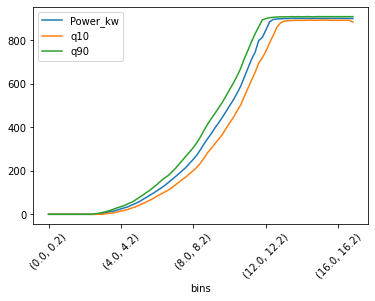

In [97]:
# pretty good replication of the power vs wind profile
power_med.plot(rot=45)

In [98]:
# it's a inverse lookup
def get_power(ws, df = power_med):
    if ws < 0:
        raise 'Not a valid ws number'
    else:
        bin_idx = bin_assigner(ws)
        return power_med.loc[[bin_idx], 'Power_kw'].values[0]
    
get_power(5.)

58.0

<AxesSubplot:>

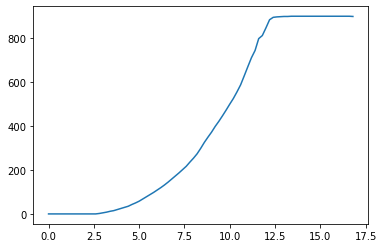

In [99]:
# recreate the plot
wind_range = np.arange(0, wmax, .2)
power_series = pd.Series([get_power(w) for w in wind_range], index=wind_range)
power_series.plot()

In [100]:
# another more advanced option -- using advanced Pandas functionality
# look-up table mean and standard deviation
bins = np.arange(0, wmax, .2)

# group data by bins
# advanced Pandas feature:
cuts = pd.cut(df.Wind_ms, bins)
gp = df.Power_kw.groupby(cuts) # iterator

lutm = gp.mean()
luts = gp.std()

# convert to an interval index
lutm.index = pd.IntervalIndex(lutm.index)
luts.index = pd.IntervalIndex(luts.index)

In [101]:
# # use bin centres for wind speed as we will be doing linear interpolation between lookup table values
wind_ms = lutm.index.mid.values

# # normalise power
power_kw = lutm.values / lutm.max()

In [102]:
# this is the basis of our look-up table
lutm.head(20)

Wind_ms
(0.0, 0.2]     0.000000
(0.2, 0.4]     0.000000
(0.4, 0.6]     0.000000
(0.6, 0.8]     0.000000
(0.8, 1.0]     0.000000
(1.0, 1.2]     0.000000
(1.2, 1.4]     0.000000
(1.4, 1.6]     0.000000
(1.6, 1.8]     0.000000
(1.8, 2.0]     0.003292
(2.0, 2.2]     0.004128
(2.2, 2.4]     0.037713
(2.4, 2.6]     0.330520
(2.6, 2.8]     1.421414
(2.8, 3.0]     3.258855
(3.0, 3.2]     5.870189
(3.2, 3.4]     9.539987
(3.4, 3.6]    13.289027
(3.6, 3.8]    17.985005
(3.8, 4.0]    22.135380
Name: Power_kw, dtype: float64

Clean it up a bit using our knowledge of the system:

In [103]:
# round power to nearest 5 watts == 0.05 kW
lutm = lutm.round(2)

# # set final power output to 900
lutm.loc[15.8:] = 900

# # make zero interval open at right ends to cover zero wind speed
lutm.loc[pd.Interval(0,.2)] = 0 

# # extend range to gusts of wind that are greater than max operating speed (25m/s) but of short duration
lutm.loc[pd.Interval(15.8,50)] = 900

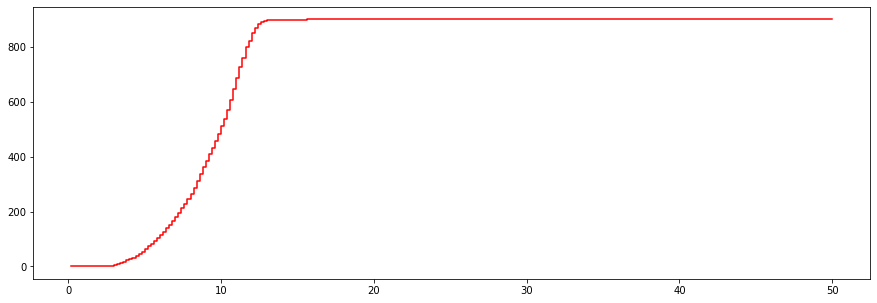

In [104]:
# compare lookup table with data
plt.figure(figsize=(15, 5))

# plot_wind_power(df)
s = plt.step(lutm.index.right, lutm.to_numpy(), color='r')
plt.show()

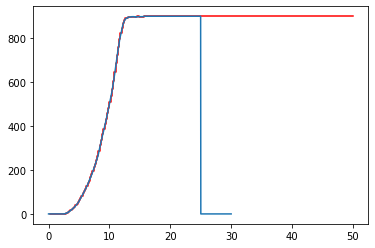

In [105]:
# # use bin centres for wind speed as we will be doing linear interpolation between lookup table values
wind_ms = lutm.index.mid.values

# # normalise power
power_kw = lutm.values / lutm.max()

@np.vectorize
def turbine_max_power_kw(wind_speed_ms, max_power_kw=900, max_wind_speed_ms=25):
    """Linear interpolation of wind-to-power look-up table."""    
    if np.isnan(wind_speed_ms).any():
        return np.nan
    
    if wind_speed_ms > max_wind_speed_ms:
        return 0
    
    right_ind = np.searchsorted(wind_ms, wind_speed_ms)
    
    if right_ind == 0:
        return 0
    
    left_ind = right_ind - 1
    
    left_wind = wind_ms[left_ind]
    right_wind = wind_ms[right_ind]

    left_pow = power_kw[left_ind]
    right_pow = power_kw[right_ind]
    
    grad = (right_pow - left_pow) / (right_wind - left_wind)
    
    return (left_pow + grad * (wind_speed_ms - left_wind)) * max_power_kw
# compare lookup table with data
# figsize(15,5)

ws = np.linspace(0,30,1000)

# plot_wind_power(df)
s = plt.step(lutm.index.right, lutm.to_numpy(), color='r')
l = plt.plot(ws, turbine_max_power_kw(ws, max_wind_speed_ms=25))

# legend([s[0],l[0]], ['look-up table', 'turbine power function'], loc='upper left')

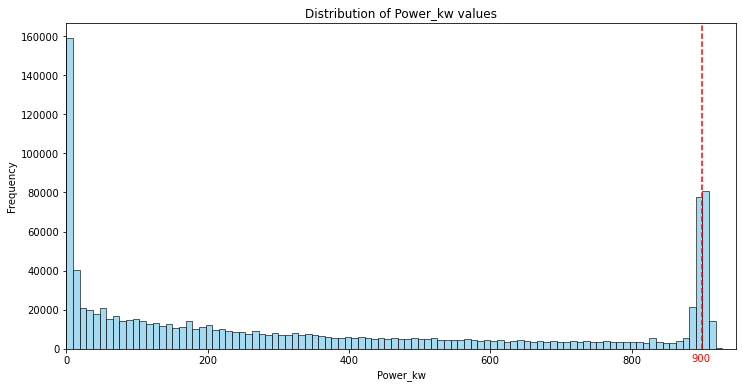

In [106]:
# Distribution of Power_kw values using sns and long x axis so we can see the distribution of the values
plt.figure(figsize=(12, 6))
sns.histplot(tt['Power_kw'], bins=100, color='skyblue')
plt.axvline(900, color='r', linestyle='--') # Add a vertical line at 900
# Add a label for the vertical line at 900 next to the line
plt.text(885, -5000, '900', rotation=0, verticalalignment='center', color='red')
plt.title('Distribution of Power_kw values')
plt.xlabel('Power_kw')
plt.ylabel('Frequency')
plt.xlim(0, tt['Power_kw'].max()+ 10)
plt.show()

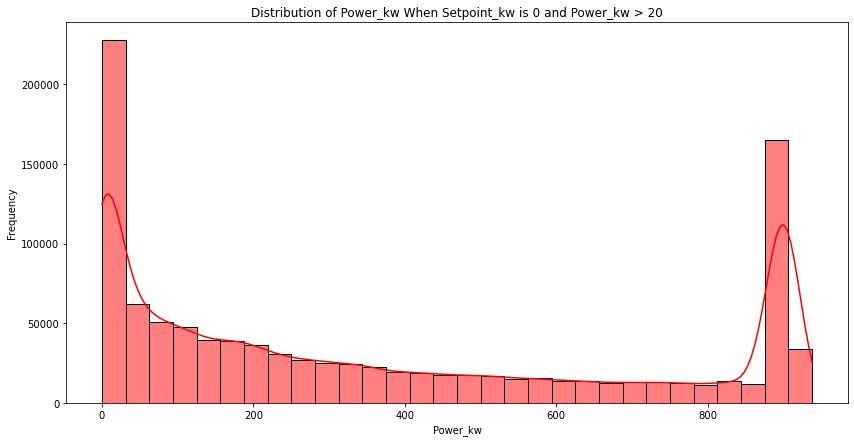

In [107]:
# Plot distribution of Power_kw when Setpoint_kw is zero
plt.figure(figsize=(14, 7))
sns.histplot(tt['Power_kw'], bins=30, kde=True, color='red')
plt.title('Distribution of Power_kw When Setpoint_kw is 0 and Power_kw > 20')
plt.xlabel('Power_kw')
plt.ylabel('Frequency')
plt.show()

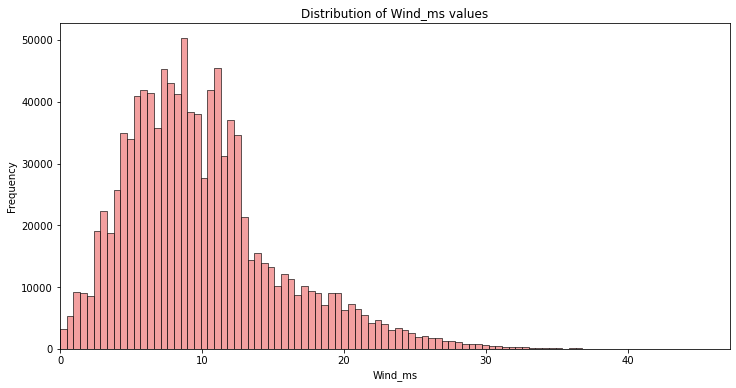

In [108]:
# Distribution of Wind_ms values using sns and long x axis so we can see the distribution of the values
plt.figure(figsize=(12, 6))
sns.histplot(tt['Wind_ms'], bins=100, color='lightcoral')
plt.title('Distribution of Wind_ms values')
plt.xlabel('Wind_ms')
plt.ylabel('Frequency')
plt.xlim(0, tt['Wind_ms'].max())
plt.show()

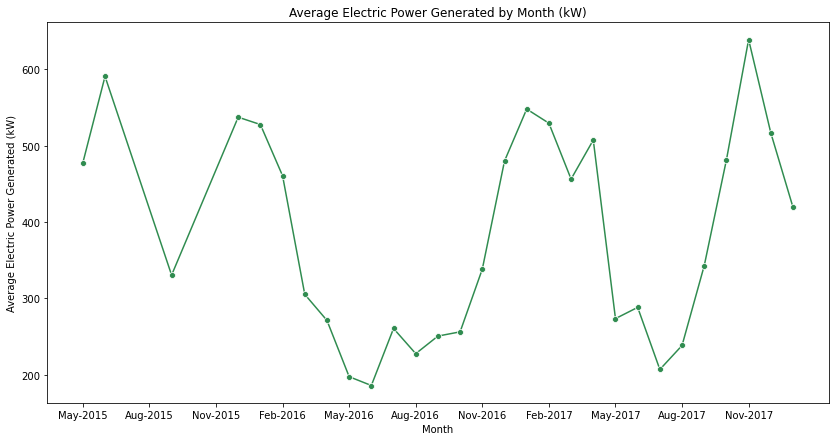

In [109]:
# Power seasonality analysis
telemetry_avg = tt.resample('M').mean()

# Plot Power_kw by month
plt.figure(figsize=(14, 7))
sns.lineplot(x=telemetry_avg.index.strftime('%b-%Y'), y='Power_kw', data=telemetry_avg, marker='o', color='#308c50')
plt.title('Average Electric Power Generated by Month (kW)')
plt.xlabel('Month')
plt.ylabel('Average Electric Power Generated (kW)')
plt.xticks(telemetry_avg.index.strftime('%b-%Y')[::3])
plt.show()

### 2: Evaluating Curtailment Based on Setpoint

Using the setpoint and actual power output, identify instances of curtailment and evaluate the magnitude of curtailment over time.


Here, we calculate the curtailment by comparing the target (setpoint) and actual power output. Instances where actual power output falls below the setpoint represent curtailment, which we can visualize over time to understand its trends and frequency.



Here, we focus on quantifying curtailment by comparing target (setpoint) and actual power. Curtailment, occurring when actual power falls below the setpoint, represents lost renewable generation. By calculating curtailment over time, we can understand its patterns and impact.



### Step 2: Calculate and Visualize Curtailment

To calculate curtailment, we subtract actual power from the setpoint. If the difference is positive, it represents curtailed energy. We then visualize these curtailments to observe patterns.

In [110]:
tt.index

DatetimeIndex(['2015-05-28 00:00:23', '2015-05-28 00:01:23',
               '2015-05-28 00:02:23', '2015-05-28 00:03:23',
               '2015-05-28 00:04:23', '2015-05-28 00:05:23',
               '2015-05-28 00:06:23', '2015-05-28 00:07:23',
               '2015-05-28 00:08:23', '2015-05-28 00:09:23',
               ...
               '2018-01-11 06:05:32', '2018-01-11 06:06:32',
               '2018-01-11 06:07:32', '2018-01-11 06:08:32',
               '2018-01-11 06:09:32', '2018-01-11 06:10:32',
               '2018-01-11 06:11:32', '2018-01-11 06:12:32',
               '2018-01-11 06:13:32', '2018-01-11 06:14:32'],
              dtype='datetime64[ns]', name='Timestamp', length=1069636, freq=None)

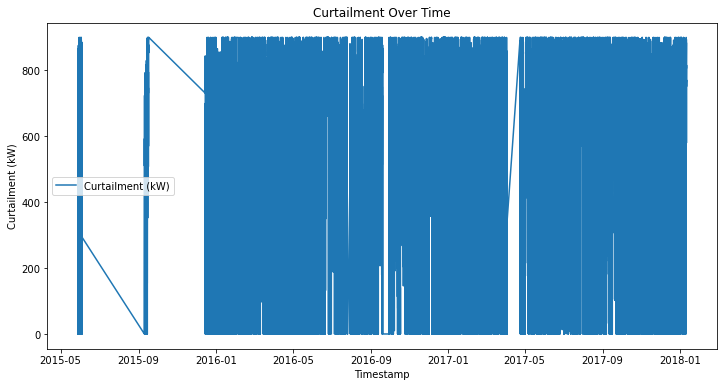

In [111]:
# Calculate Curtailment
tt['Curtailment'] = tt['Setpoint_kw'] - tt['Power_kw']
tt['Curtailment'] = tt['Curtailment'].apply(lambda x: max(0, x))

# Plotting curtailment over time
plt.figure(figsize=(12, 6))
plt.plot(tt.index, tt['Curtailment'], label='Curtailment (kW)')
plt.title('Curtailment Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Curtailment (kW)')
plt.legend()
plt.show()

In [112]:
# some suggested model parameters
# model parameter
baseload_capacity_mw = 30
wind_capacity_mw = 50
peak_load_mw = 40
interconnector_capacity_mw = 40

### Task 3: Identifying Solutions to Minimize Curtailment

Discuss potential solutions based on curtailment analysis. Consider demand-side responses. A quick comparison of demand and power is as follows:

In this final section, we discuss potential solutions for reducing curtailment based on the insights gained from the analysis above. Solutions might include adjusting turbine operations, integrating storage, or implementing demand response strategies to balance excess generation.



With curtailment trends identified, our final task is to discuss potential solutions. We’ll explore methods like adjusting turbine parameters, integrating storage, or implementing demand-side management to reduce curtailment and enhance system stability.



### Step 3: Discuss Curtailment Reduction Strategies

Based on the observed curtailment trends, this section focuses on identifying practical solutions. Strategies might include storage integration, operational adjustments, or demand response options to help balance excess generation.

In [113]:
# Loading the datasets
demand_data = pd.read_csv('Residential_demand.csv')

# Previewing the data
demand_data.head(), tt.head()

(             Timestamp  Demand_mean_kw  N_households
 0  2017-01-01 00:00:00        0.220106          5428
 1  2017-01-01 00:30:00        0.205945          5429
 2  2017-01-01 01:00:00        0.189090          5429
 3  2017-01-01 01:30:00        0.173118          5429
 4  2017-01-01 02:00:00        0.159051          5429,
                      Power_kw  Setpoint_kw  Wind_ms  Curtailment
 Timestamp                                                       
 2015-05-28 00:00:23      80.0        900.0      4.9        820.0
 2015-05-28 00:01:23      78.0        900.0      5.4        822.0
 2015-05-28 00:02:23      52.0        900.0      4.9        848.0
 2015-05-28 00:03:23      57.0        900.0      4.6        843.0
 2015-05-28 00:04:23      54.0        900.0      4.6        846.0)

In [114]:
# Converting timestamps to datetime format for comparison
demand_data['Timestamp'] = pd.to_datetime(demand_data['Timestamp'], errors='coerce')
tt = pd.read_csv('turbine_telemetry.csv')
tt['Timestamp'] = pd.to_datetime(tt['Timestamp'], errors='coerce')

# Checking for unique timestamps in each to see if they match
unique_residential_timestamps = demand_data['Timestamp'].dropna().unique()
unique_turbine_timestamps = tt['Timestamp'].dropna().unique()

# Finding the intersection of timestamps
matching_timestamps = set(unique_residential_timestamps).intersection(unique_turbine_timestamps)

# Checking the number of matching timestamps
num_matching_timestamps = len(matching_timestamps)
total_residential_timestamps = len(unique_residential_timestamps)
total_turbine_timestamps = len(unique_turbine_timestamps)

# Outputting summary of results
(num_matching_timestamps, total_residential_timestamps, total_turbine_timestamps)

(1, 17568, 1069636)

In [115]:


# Set Timestamp as the index for resampling
demand_data.set_index('Timestamp', inplace=True)
tt.set_index('Timestamp', inplace=True)

# Resampling both datasets to hourly frequency
residential_resampled = demand_data.resample('H').mean()
turbine_resampled = tt.resample('H').mean()

# Interpolating missing values after resampling
residential_resampled_interpolated = residential_resampled.interpolate(method='linear')
turbine_resampled_interpolated = turbine_resampled.interpolate(method='linear')

# Resetting index if you want Timestamp as a column again
residential_resampled_interpolated.reset_index(inplace=True)
turbine_resampled_interpolated.reset_index(inplace=True)

# Merging the resampled datasets on Timestamp
aligned_data = pd.merge(residential_resampled_interpolated, turbine_resampled_interpolated, on='Timestamp', how='inner')

# Displaying the first few rows of the aligned data
aligned_data.head()


,Timestamp,Demand_mean_kw,N_households,Power_kw,Setpoint_kw,Wind_ms
0,2017-01-01 00:00:00,0.213026,5428.5,896.150000,900.0,14.963333
1,2017-01-01 01:00:00,0.181104,5429.0,905.350000,900.0,16.731667
2,2017-01-01 02:00:00,0.153353,5429.0,906.170213,900.0,17.995745
3,2017-01-01 03:00:00,0.133578,5429.0,904.109589,900.0,17.183562
4,2017-01-01 04:00:00,0.122200,5429.0,904.316667,900.0,16.130000


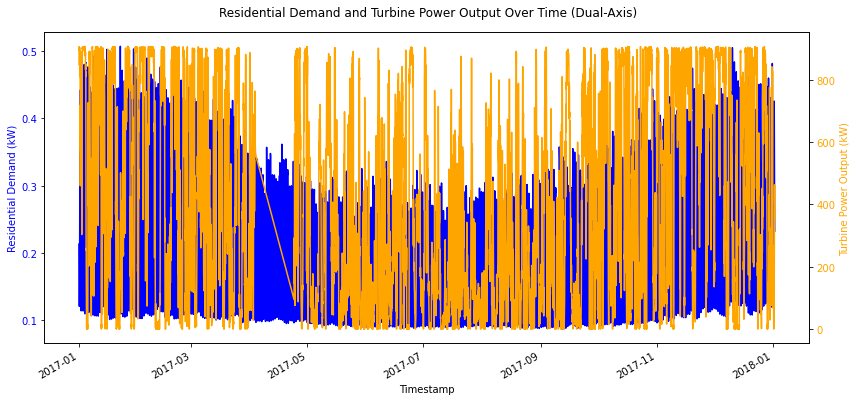

In [116]:
# Dual-Axis Line Plot: Plotting residential demand and turbine power output on different y-axes

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting residential demand on the primary y-axis
ax1.plot(aligned_data['Timestamp'], aligned_data['Demand_mean_kw'], label='Residential Demand (kW)', color='blue')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Residential Demand (kW)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Creating a secondary y-axis for turbine power output
ax2 = ax1.twinx()
ax2.plot(aligned_data['Timestamp'], aligned_data['Power_kw'], label='Turbine Power Output (kW)', color='orange')
ax2.set_ylabel('Turbine Power Output (kW)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Adding title and formatting
fig.suptitle('Residential Demand and Turbine Power Output Over Time (Dual-Axis)')
fig.tight_layout()
fig.autofmt_xdate()
plt.show()
